In [1]:
from itertools import combinations

import numpy as np
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from matplotlib.markers import MarkerStyle
import seaborn as sns


df = pd.read_csv("Iris.csv").drop(["Id"], axis=1)

df = df.map(lambda element: pd.NA if element in ["", " ", None] else element)
undefined_data = round((df.isna().any(axis=1).sum() / df.size) * 100, 3)

class_names = df["Species"].unique().tolist()
objects_in_classes = df["Species"].value_counts().to_list()

col_labels = ["Size", "Features", "Classes"] + class_names + ["Undefined objects"]
cells = [[df["Species"].size, len(df.columns) - 1, len(class_names)] + objects_in_classes + [undefined_data]]
dataset_info = pd.DataFrame(cells, columns=col_labels)

print(dataset_info)

   Size  Features  Classes  Iris-setosa  Iris-versicolor  Iris-virginica  \
0   150         4        3           50               50              50   

   Undefined objects  
0                0.0  


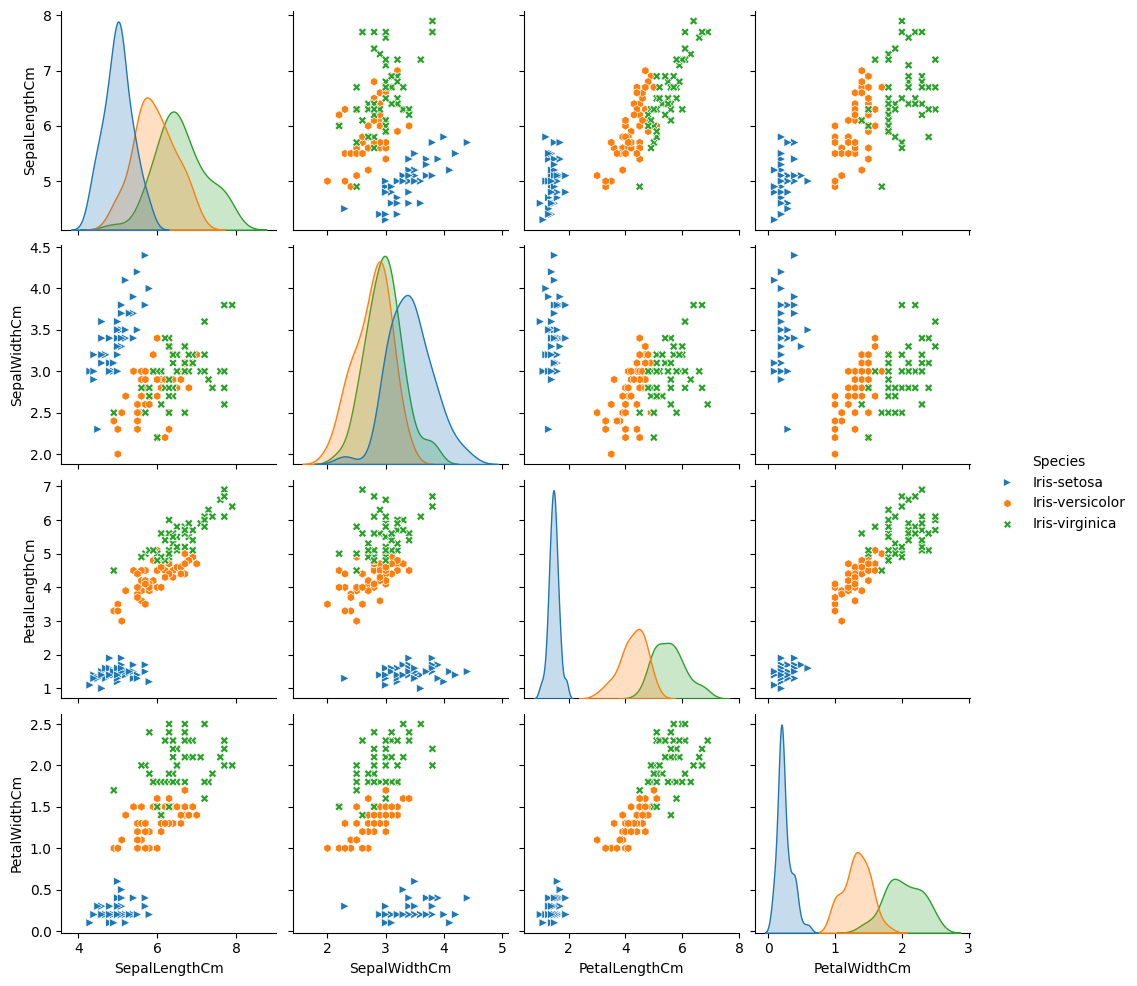

In [2]:
class_markers = dict()
class_colors = dict()
for i, class_name in enumerate(class_names):
    class_markers[class_name]= MarkerStyle.filled_markers[(i + 1) * 5]
    class_colors[class_name] = f"C{i}"
    
sns.pairplot(df, hue="Species", markers=list(class_markers.values()))
plt.show()



PEARSON

All objects:
        feature_1      feature_2      corr       p_value
0   SepalLengthCm  SepalLengthCm  1.000000  0.000000e+00
1   SepalLengthCm   SepalWidthCm -0.109369  1.827652e-01
2   SepalLengthCm  PetalLengthCm  0.871754  1.038454e-47
3   SepalLengthCm   PetalWidthCm  0.817954  2.314849e-37
4    SepalWidthCm  SepalLengthCm -0.109369  1.827652e-01
5    SepalWidthCm   SepalWidthCm  1.000000  0.000000e+00
6    SepalWidthCm  PetalLengthCm -0.420516  8.429366e-08
7    SepalWidthCm   PetalWidthCm -0.356544  7.523891e-06
8   PetalLengthCm  SepalLengthCm  0.871754  1.038454e-47
9   PetalLengthCm   SepalWidthCm -0.420516  8.429366e-08
10  PetalLengthCm  PetalLengthCm  1.000000  0.000000e+00
11  PetalLengthCm   PetalWidthCm  0.962757  5.776661e-86
12   PetalWidthCm  SepalLengthCm  0.817954  2.314849e-37
13   PetalWidthCm   SepalWidthCm -0.356544  7.523891e-06
14   PetalWidthCm  PetalLengthCm  0.962757  5.776661e-86
15   PetalWidthCm   PetalWidthCm  1.000000  0.000000e+00

Iris-s

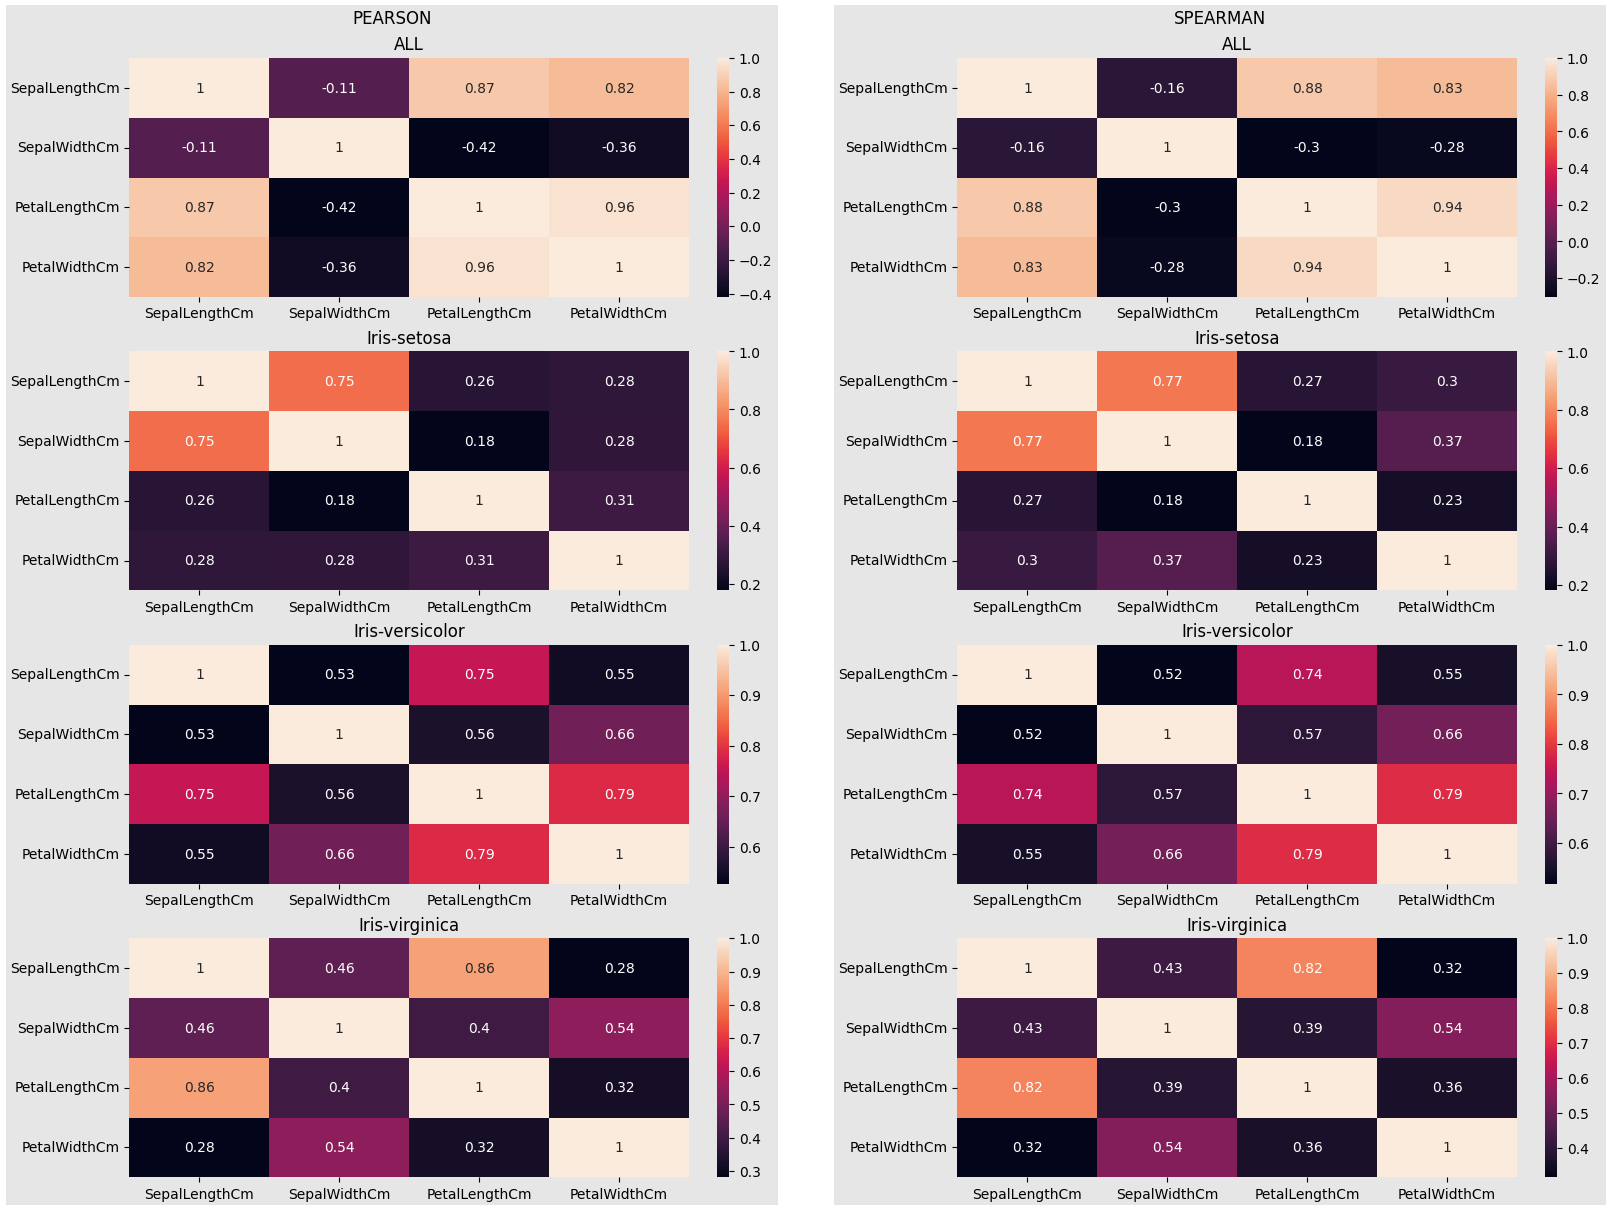

In [3]:
def compute_corr_matrix(df: pd.DataFrame, method: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    corr_and_p_value_matrix = []
    corr_matrix = pd.DataFrame(index=df.columns, columns=df.columns, dtype=float)
    corr_func = stats.pearsonr if method == "pearson" else stats.spearmanr

    for feature_1 in df.columns:
        for feature_2 in df.columns:
            res = corr_func(df[feature_1], df[feature_2])
            corr_matrix.at[feature_1, feature_2] = res.statistic
            corr_and_p_value_matrix.append({"feature_1": feature_1, 
                                            "feature_2": feature_2, 
                                            "corr": res.statistic, 
                                            "p_value": res.pvalue})

    return corr_matrix, pd.DataFrame(corr_and_p_value_matrix)


def draw_corr_matrices(all_objects: pd.DataFrame, objects_by_class: dict, class_names: list) -> plt.Figure:
    fig = plt.figure(layout="constrained", figsize=[16, 12])
    subfigs = fig.subfigures(1, 2, wspace=0.07)

    for i, method in enumerate(["pearson", "spearman"]):
        print("\n\n", method.upper(), "\n", sep="")
        subfigs[i].suptitle(method.upper())
        subfigs[i].set_facecolor("0.9")
        axs = subfigs[i].subplots(4, 1)

        corr_matrix, corr_and_p_value_matrix = compute_corr_matrix(all_objects, method)
        print("All objects:", "\n", corr_and_p_value_matrix, sep="")
        sns.heatmap(corr_matrix, annot=True, ax=axs[0])
        axs[0].set_title("ALL")
        for j, class_name in enumerate(class_names):
            corr_matrix, corr_and_p_value_matrix = compute_corr_matrix(objects_by_class[class_name], method)
            print("\n", class_name, ":\n", corr_and_p_value_matrix, sep="")
            sns.heatmap(corr_matrix, annot=True, ax=axs[j + 1])
            axs[j + 1].set_title(class_name)

    return fig


all_objects = df.drop(["Species"], axis=1)
objects_by_class = dict()
for class_name in class_names:
    objects_by_class[class_name] = df[df["Species"] == class_name].drop(["Species"], axis=1)

corr_matrices_fig = draw_corr_matrices(all_objects, objects_by_class, class_names)
plt.show()

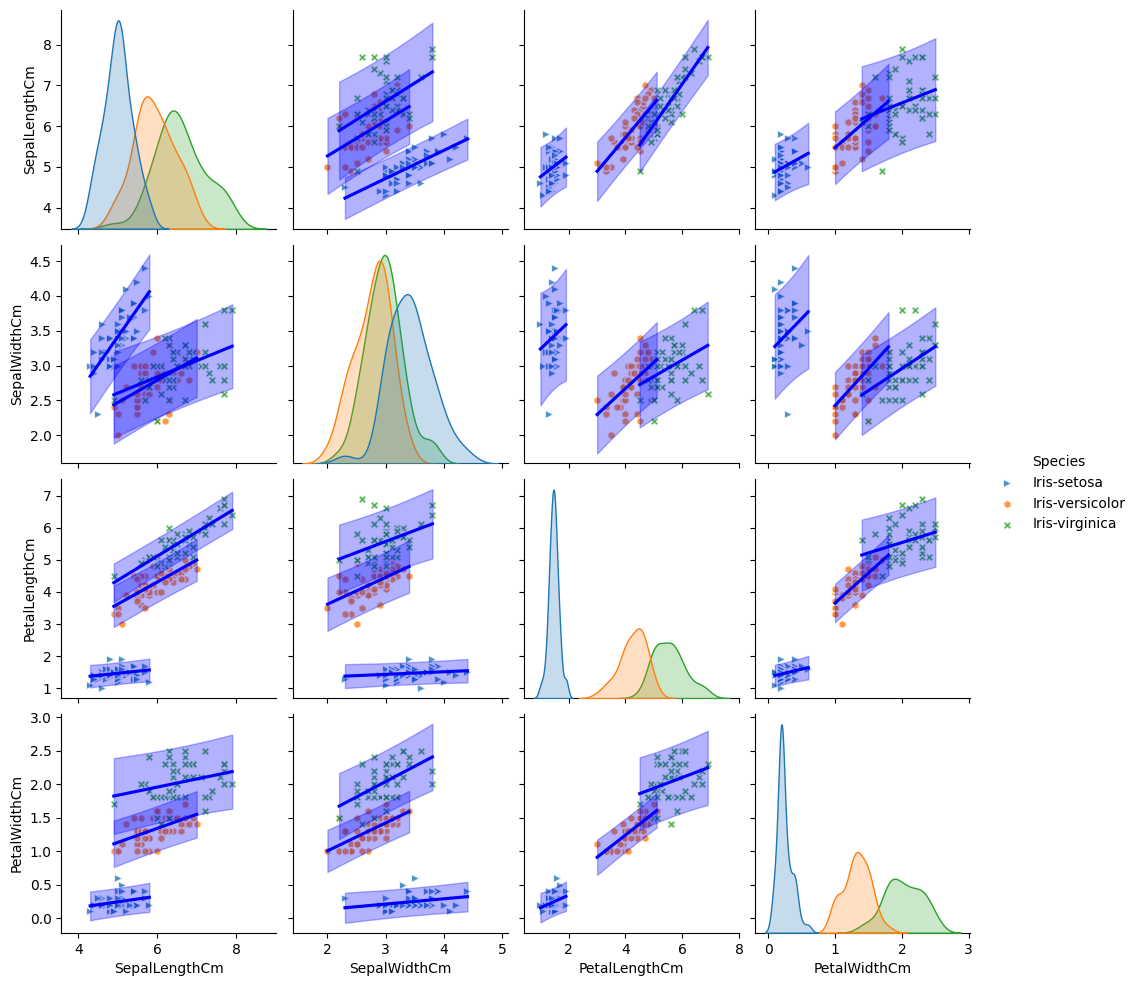

In [4]:
def compute_prod_bands(linreg: LinearRegression, x: np.ndarray, y: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    y_pred = linreg.predict(x)
    mse = mean_squared_error(y, y_pred)
    n = len(x)
    mean_x = np.mean(x)
    sum_of_sd = np.sum((x - mean_x)**2)
    se_pred = np.sqrt(mse * (1 + 1/n + (x - mean_x)**2 / sum_of_sd))

    alpha = 0.05
    dof = n - 2
    t_val = stats.t.ppf(1 - alpha/2, dof)

    pred_upper = (y_pred + t_val * se_pred).flatten()
    pred_lower = (y_pred - t_val * se_pred).flatten()

    return pred_lower, pred_upper


reg_fig = sns.pairplot(df, hue="Species", kind="reg", 
                       plot_kws=dict(ci=None, x_ci="ci", line_kws=dict(color="b"), 
                                     scatter_kws=dict(edgecolor="white")), 
                       markers=list(class_markers.values())).figure

axs = reg_fig.get_axes()
feature_names = df.columns.to_list()[:-1]
for i, feature_name in enumerate(feature_names):
    for j, next_feature_name in enumerate(feature_names):
        if i != j:
            for class_name in class_names:
                objs_sorted_by_feature = objects_by_class[class_name].sort_values(feature_name)
                x = objs_sorted_by_feature[feature_name].to_numpy().reshape((-1, 1))
                y = objs_sorted_by_feature[next_feature_name].to_numpy().reshape((-1, 1))
                linreg = LinearRegression()
                linreg.fit(x, y)
                pred_lower, pred_upper = compute_prod_bands(linreg, x, y)
                axs[j*4 + i].fill_between(x.flatten(), pred_lower, pred_upper, color="b", alpha=0.3)

plt.show()

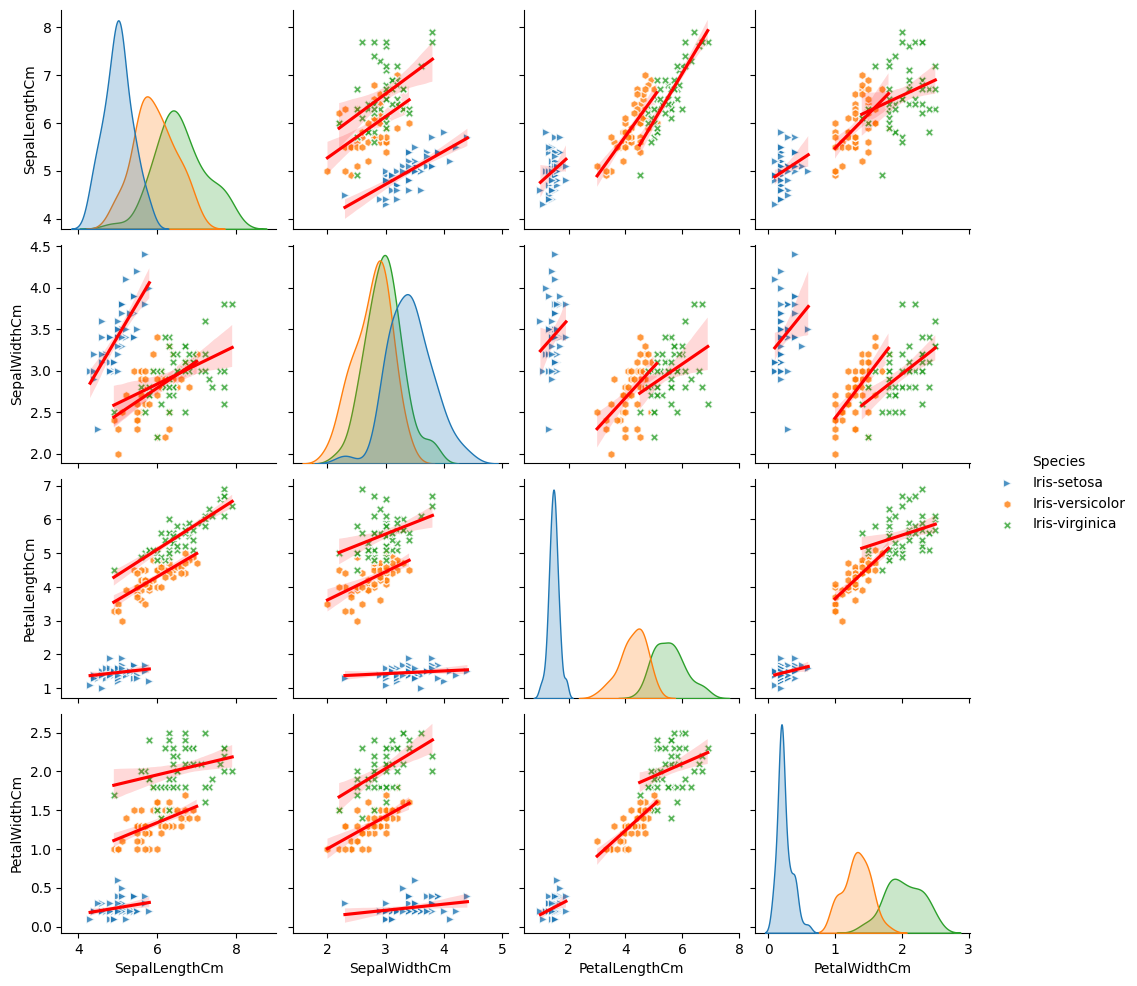

In [5]:
sns.pairplot(df, hue="Species", kind="reg", 
             plot_kws=dict(ci=95, x_ci="ci", line_kws=dict(color="r"), 
                           scatter_kws=dict(edgecolor="white")), 
             markers=list(class_markers.values()))
plt.show()

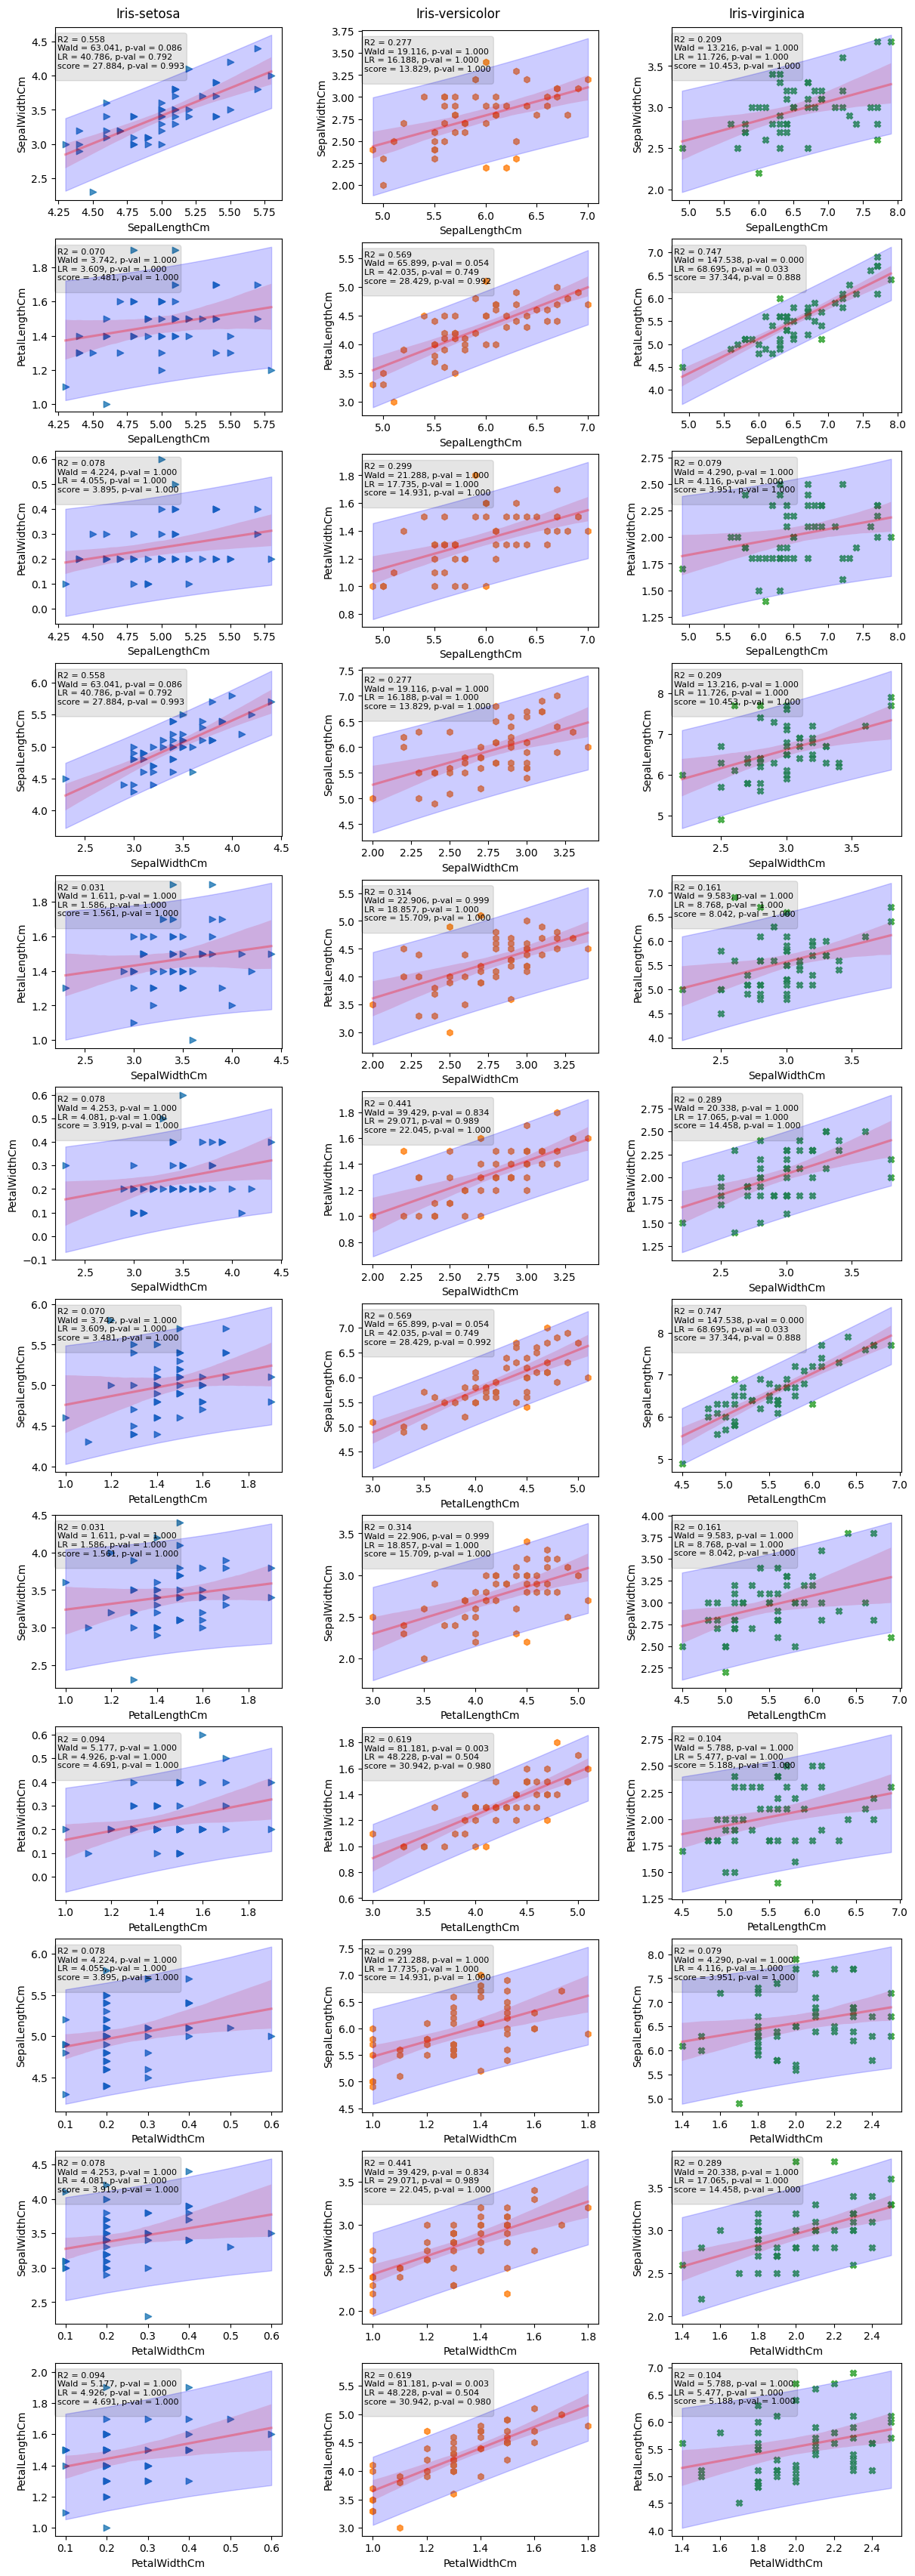

In [6]:
def likelihood(r2: float, n: int) -> float:
    return -n * np.log(1 - r2)


def wald(r2: float, n: int) -> float:
    return (n * r2) / (1 - r2)


def score(r2: float, n: int) -> float:
    return n * r2


reg_with_criteria_fig = plt.figure(layout="constrained", figsize=[12, 34])
subfigs = reg_with_criteria_fig.subfigures(1, 3, wspace=0.07)

for class_name, subfig in zip(class_names, subfigs):
    subfig.suptitle(class_name)
    axs = subfig.subplots(12, 1)
    ax_idx = 0

    for feature_name in feature_names:
        objs_sorted_by_feature = objects_by_class[class_name].sort_values(feature_name)
        x = objs_sorted_by_feature[feature_name].to_numpy().reshape((-1, 1))

        for next_feature_name in feature_names:
            if feature_name != next_feature_name:
                y = objs_sorted_by_feature[next_feature_name].to_numpy().reshape((-1, 1))

                linreg = LinearRegression()
                linreg.fit(x, y)

                # Расчёт критериев R2, Wald, LR, score
                text = ""
                n = y.shape[0]
                r2 = linreg.score(x, y)
                text += f"R2 = {r2:.3f}\n"

                W = wald(r2, n)
                W_p_value = stats.chi2.sf(W, n - 1)
                text += f"Wald = {W:.3f}, p-val = {W_p_value:.3f}\n"
                
                LR = likelihood(r2, n)
                LR_p_value = stats.chi2.sf(LR, n - 1)
                text += f"LR = {LR:.3f}, p-val = {LR_p_value:.3f}\n"

                score_value = score(r2, n)
                score_p_value = stats.chi2.sf(score_value, n - 1)
                text += f"score = {score_value:.3f}, p-val = {score_p_value:.3f}\n"

                # Отрисовка
                sns.regplot(x=x, y=y, ci=95, x_ci="ci", ax=axs[ax_idx], 
                            color=class_colors[class_name], 
                            line_kws=dict(color="r", alpha=0.3),
                            marker=class_markers[class_name])
                
                pred_lower, pred_upper = compute_prod_bands(linreg, x, y)
                axs[ax_idx].fill_between(x.flatten(), pred_lower, pred_upper, color="b", alpha=0.2)

                axs[ax_idx].text(0.01, 0.95, text,
                                 transform=axs[ax_idx].transAxes, fontsize=8,
                                 verticalalignment="top", horizontalalignment="left",
                                 bbox=dict(boxstyle="round", facecolor="black", alpha=0.1))
                
                axs[ax_idx].set_xlabel(feature_name)
                axs[ax_idx].set_ylabel(next_feature_name)
                
                ax_idx += 1
                
plt.show()

SepalLengthCm:

All classes:
   df_b  df_w      F-test       p-value
0     2   148  119.264502  1.669669e-31 

Between pairs of classes:
           class_1          class_2  df_b  df_w      F-test       p-value
0      Iris-setosa  Iris-versicolor     1    98  110.691152  8.985235e-18
1      Iris-setosa   Iris-virginica     1    98  236.735022  6.892546e-28
2  Iris-versicolor   Iris-virginica     1    98   31.687502  1.724856e-07 

SepalWidthCm:

All classes:
   df_b  df_w     F-test       p-value
0     2   148  47.364461  1.327917e-16 

Between pairs of classes:
           class_1          class_2  df_b  df_w     F-test       p-value
0      Iris-setosa  Iris-versicolor     1    98  86.169866  4.362239e-15
1      Iris-setosa   Iris-virginica     1    98  39.556364  8.916634e-09
2  Iris-versicolor   Iris-virginica     1    98  10.276902  1.819100e-03 

PetalLengthCm:

All classes:
   df_b  df_w       F-test       p-value
0     2   148  1179.034328  3.051976e-91 

Between pairs of classes

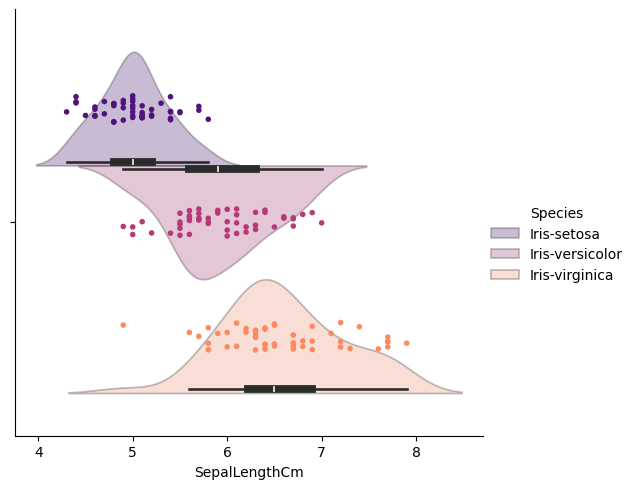

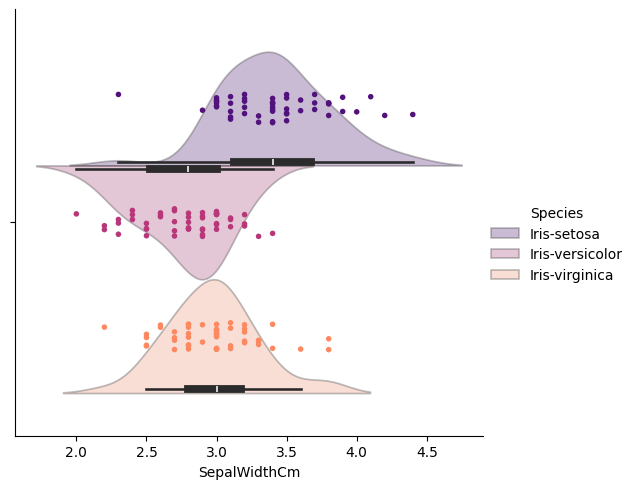

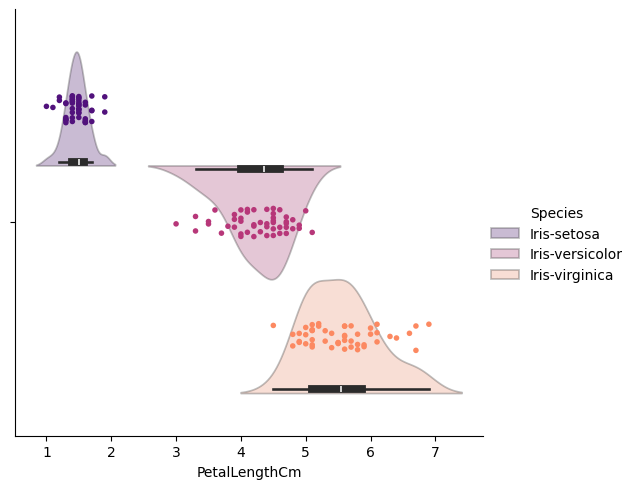

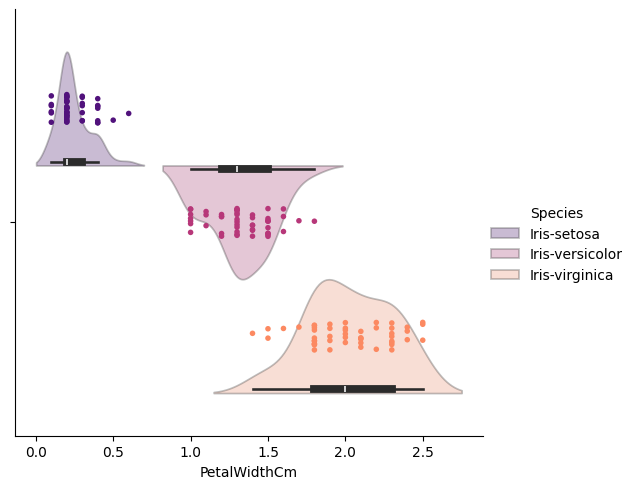

In [12]:
def f_test(feature_name: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    f_all = dict()
    f_all["df_b"] = len(class_names) - 1
    f_all["df_w"] = -f_all["df_b"]
    feature_by_class = dict()
    for class_name in class_names:
        feature_by_class[class_name] = objects_by_class[class_name][feature_name]
        f_all["df_w"] += feature_by_class[class_name].count()
    result = stats.f_oneway(*feature_by_class.values())
    f_all["F-test"] = result.statistic
    f_all["p-value"] = result.pvalue

    f_pairs = list()
    for class_name_1, class_name_2 in combinations(class_names, 2):
        f_pair = stats.f_oneway(feature_by_class[class_name_1], feature_by_class[class_name_2])
        f_pairs.append({"class_1": class_name_1,
                        "class_2": class_name_2,
                        "df_b": 1,
                        "df_w": feature_by_class[class_name_1].count() * 2 - 2,
                        "F-test": f_pair.statistic,
                        "p-value": f_pair.pvalue})
    
    return pd.DataFrame(f_all, index=[0]), pd.DataFrame(f_pairs)


def draw_raincloud(data: pd.DataFrame, x: str, hue: str, palette="magma"):
    g = sns.catplot(data=data, x=x, hue=hue, kind="violin", palette=palette, alpha=0.3, split=True, dodge=True)
    sns.stripplot(data=data, x=x, hue=hue, palette=palette, legend=None,
                  alpha=1, jitter=True, dodge=True, ax=g.ax, size=4)


for feature_name in feature_names:
    f_all, f_pairs = f_test(feature_name)
    print("===================")
    print(feature_name + ":\n")
    print("All classes:")
    print(f_all, "\n")
    print("Between pairs of classes:")
    print(f_pairs, "\n")
    draw_raincloud(df, feature_name, "Species")

plt.show()